#### Importing libraries and packages

In [1]:
import cv2  
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
import geopandas as gpd
import os
import shutil
import glob
import zipfile
import pickle

from rasterio.transform import rowcol
from shapely.ops import unary_union
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
from concurrent.futures import ProcessPoolExecutor, as_completed

%matplotlib inline

#### Loading and preprocessing data

In [3]:
# Path to the ZIP file
zip_file_path = 'archive.zip'

# Target directory for extracting the files
extraction_path = 'Sentinel/'

# Create the directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Extraction completed.")

Extraction completed.


In [4]:
# Path to the GeoJSON file
geojson_path = os.path.join(extraction_path, 'deforestation_labels.geojson')

# Read the GeoJSON file
df = gpd.read_file(geojson_path)

# Display the first few rows of the dataframe
df

,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((35.79130 50.17406, 35.79277 50.17354..."
1,2016-04-09,36UXA,"POLYGON ((35.77653 50.10271, 35.77810 50.10318..."
2,2016-04-09,36UXA,"POLYGON ((35.78621 50.01277, 35.78616 50.01369..."
3,2016-04-09,36UXA,"POLYGON ((35.78007 50.00556, 35.78189 50.00557..."
4,2016-04-09,36UXA,"POLYGON ((35.79781 49.99568, 35.79908 49.99582..."
...,...,...,...
5691,2019-09-09,36UYA,"POLYGON ((36.37494 50.17378, 36.37506 50.17376..."
5692,2019-09-09,36UYA,"POLYGON ((36.37849 50.17354, 36.37851 50.17352..."
5693,2019-09-09,36UYA,"POLYGON ((35.91477 50.22407, 35.91472 50.22394..."
5694,2019-10-26,36UYA,"POLYGON ((36.88312 50.26589, 36.88408 50.26489..."


In [5]:
# Print the CRS to confirm it's correctly set
print("CRS of the GeoDataFrame:", df.crs)

CRS of the GeoDataFrame: EPSG:4326


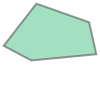

In [6]:
df['geometry'][0]

In [7]:
RASTER_PATH = 'Final project/Untitled Folder/Sentinel/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_TCI.jp2'

try:
    with rasterio.open(RASTER_PATH, "r", driver='JP2OpenJPEG') as src:
        raster_image = src.read()
        raster_meta = src.meta
    # You can add more code here to process the raster image and metadata
except FileNotFoundError:
    print("File not found. Please check the file path.")

In [8]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 699960.0,
        0.0, -10.0, 5600040.0)}

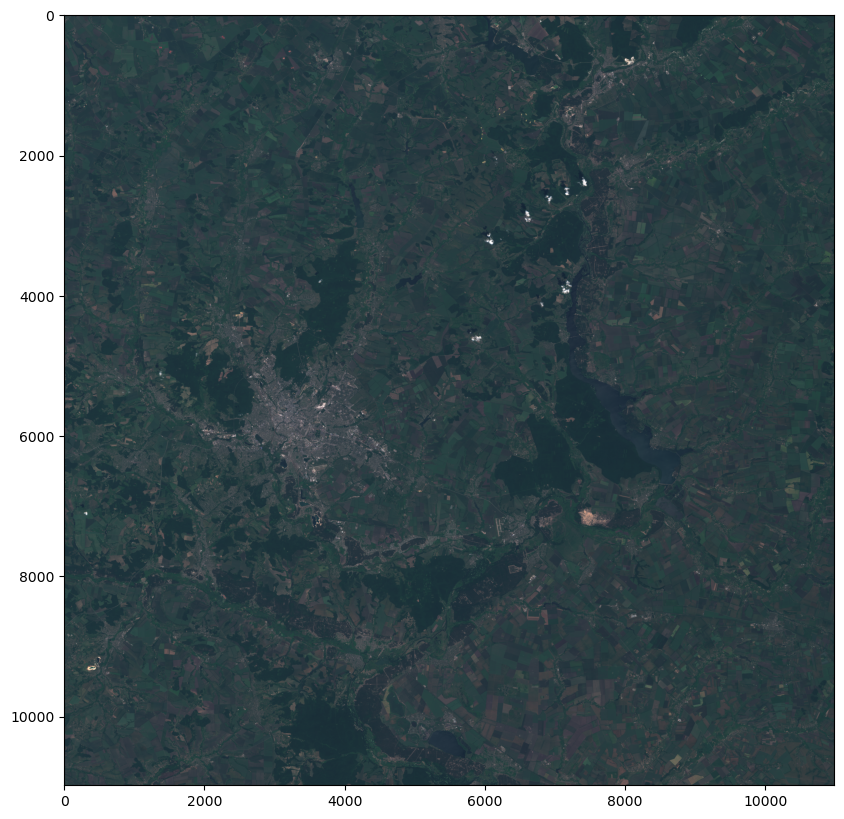

In [9]:
raster_img = reshape_as_image(raster_image)
plt.figure(figsize=(10, 10))
plt.imshow(raster_img)

In [10]:
# Transform GeoDataFrame to match the CRS of the raster data
df = df.to_crs("EPSG:32636")

# Check the first few records after transformation
print(df.head())

# Confirm the new CRS
print("Transformed CRS of the GeoDataFrame:", df.crs)

     img_date   tile                                           geometry
0  2016-04-09  36UXA  POLYGON ((699307.129 5561713.193, 699414.418 5...
1  2016-04-09  36UXA  POLYGON ((698548.100 5553743.058, 698658.019 5...
2  2016-04-09  36UXA  POLYGON ((699613.313 5543770.618, 699605.429 5...
3  2016-04-09  36UXA  POLYGON ((699203.094 5542952.982, 699333.117 5...
4  2016-04-09  36UXA  POLYGON ((700515.258 5541902.106, 700605.663 5...
Transformed CRS of the GeoDataFrame: EPSG:32636


In [11]:
def poly_from_utm(polygon, transform):
    # Merge polygons using unary_union
    poly = unary_union([polygon])
    
    # Get pixel coordinates of the polygon's exterior points
    rows, cols = zip(*[rowcol(transform, *pt) for pt in poly.exterior.coords])
    
    # Convert rows and cols to a polygon
    poly_pts = list(zip(cols, rows))
    return Polygon(poly_pts)

with rasterio.open(RASTER_PATH) as src:
    # Creating binary mask
    poly_shp = []

    for num, row in df.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly_shp.append(poly_from_utm(row['geometry'], src.transform))
        elif row['geometry'].geom_type == 'MultiPolygon':
            for p in row['geometry'].geoms:
                poly_shp.append(poly_from_utm(p, src.transform))


# Creating binary mask
poly_shp = []
im_size = (src.meta['height'], src.meta['width'])

for num, row in df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly_shp.append(poly_from_utm(row['geometry'], src.meta['transform']))
    elif row['geometry'].geom_type == 'MultiPolygon':
        for p in row['geometry'].geoms:
            poly_shp.append(poly_from_utm(p, src.meta['transform']))


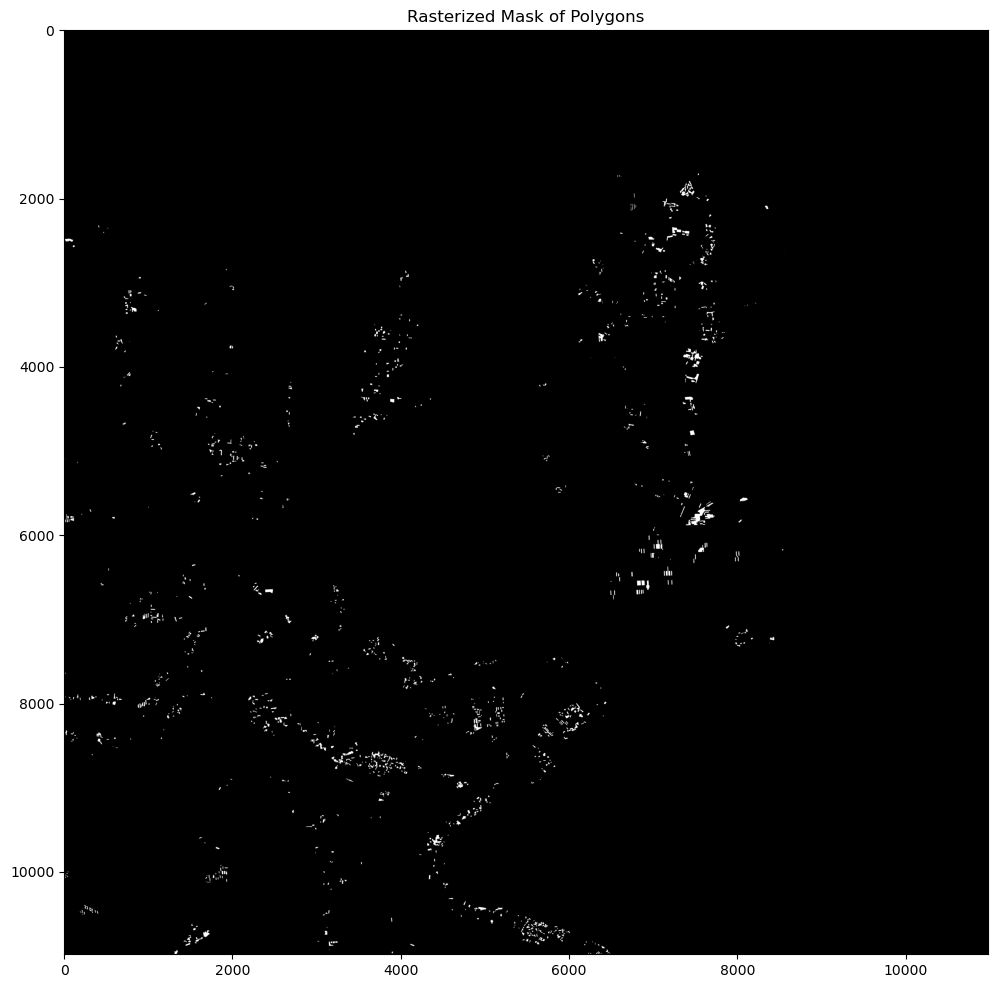

In [12]:
im_size = (src.height, src.width)

# Create a mask from the polygons
mask = rasterize(shapes=poly_shp, out_shape=im_size)

# Plot the mask
plt.figure(figsize=(12, 12))
plt.imshow(mask, cmap='gray')  # Using a grayscale colormap
plt.title("Rasterized Mask of Polygons")
plt.show()


In [27]:
def load_and_preprocess_image(image_path, max_dimension=1024):
    img = cv2.imread(image_path, 0)  # 0 for grayscale
    height, width = img.shape
    scale = max_dimension / max(height, width)
    resized_img = cv2.resize(img, (int(width * scale), int(height * scale)))
    return resized_img

def preprocess_and_save_images(base_dataset_path, dev_dataset_path, max_dimension=1024):
    if not os.path.exists(dev_dataset_path):
        os.makedirs(dev_dataset_path)

    for folder in os.listdir(base_dataset_path):
        img_data_path = os.path.join(base_dataset_path, folder, "*.SAFE/GRANULE/*/IMG_DATA/*_TCI.jp2")
        tci_image_files = glob.glob(img_data_path)
        
        for image_file in tci_image_files:
            # Revised code to handle the path
            path_parts = image_file.split(os.sep)
            if len(path_parts) >= 3:
                subdirectory_name = path_parts[-3]
            else:
                print(f"Unexpected path structure: {image_file}")
                continue  # Skip this file
            
            dest_subdirectory_path = os.path.join(dev_dataset_path, subdirectory_name)
            if not os.path.exists(dest_subdirectory_path):
                os.makedirs(dest_subdirectory_path)
                
            preprocessed_image = load_and_preprocess_image(image_file, max_dimension)
            dest_image_path = os.path.join(dest_subdirectory_path, os.path.basename(image_file).replace('.jp2', '.jpg'))
            cv2.imwrite(dest_image_path, preprocessed_image, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

base_dataset_path = 'Sentinel/'
development_dataset_path = 'Outer dir'
preprocess_and_save_images(base_dataset_path, development_dataset_path)

In [28]:
def extract_sift_features_from_directory(directory):
    sift = cv2.SIFT_create()
    features = {}

    for subdir, _, _ in os.walk(directory):
        image_files = glob.glob(os.path.join(subdir, '*.jpg'))
        for image_path in image_files:
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            keypoints, descriptors = sift.detectAndCompute(img, None)
            if descriptors is not None:
                features[image_path] = descriptors

    return features

# Extract features from each image in the subfolders of 'Outer dir'
outer_dir_features = extract_sift_features_from_directory('Outer dir')

# Save the extracted features
with open('outer_dir_features.pkl', 'wb') as f:
    pickle.dump(outer_dir_features, f)


In [32]:
def match_features(features1, features2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(features1, features2, k=2)

    # Apply ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    return len(good_matches)

# Load the features
with open('outer_dir_features.pkl', 'rb') as f:
    features = pickle.load(f)

match_threshold = 69 

for img_path1 in features:
    for img_path2 in features:
        if img_path1 != img_path2:
            num_matches = match_features(features[img_path1], features[img_path2])
            if num_matches > match_threshold:
                print(f"Match found: {img_path1} and {img_path2}")



Match found: Outer dir\L1C_T36UXA_A007240_20180726T084437\T36UXA_20180726T084009_TCI.jpg and Outer dir\L1C_T36UXA_A016220_20180731T084204\T36UXA_20180731T083601_TCI.jpg
Match found: Outer dir\L1C_T36UXA_A007383_20180805T084554\T36UXA_20180805T083559_TCI.jpg and Outer dir\L1C_T36UXA_A007526_20180815T084148\T36UXA_20180815T084009_TCI.jpg
Match found: Outer dir\L1C_T36UXA_A007383_20180805T084554\T36UXA_20180805T083559_TCI.jpg and Outer dir\L1C_T36UXA_A007669_20180825T084235\T36UXA_20180825T083549_TCI.jpg
Match found: Outer dir\L1C_T36UXA_A007383_20180805T084554\T36UXA_20180805T083559_TCI.jpg and Outer dir\L1C_T36UXA_A007812_20180904T084339\T36UXA_20180904T083549_TCI.jpg
Match found: Outer dir\L1C_T36UXA_A007383_20180805T084554\T36UXA_20180805T083559_TCI.jpg and Outer dir\L1C_T36UXA_A016220_20180731T084204\T36UXA_20180731T083601_TCI.jpg
Match found: Outer dir\L1C_T36UXA_A007383_20180805T084554\T36UXA_20180805T083559_TCI.jpg and Outer dir\L1C_T36UXA_A016363_20180810T084438\T36UXA_20180810T0

In [33]:
import numpy as np

# Collect the number of matches for each image pair
match_counts = []

for img_path1 in features:
    for img_path2 in features:
        if img_path1 != img_path2:
            num_matches = match_features(features[img_path1], features[img_path2])
            match_counts.append(num_matches)

# Analyze the distribution of match counts
match_counts = np.array(match_counts)
print(f"Average number of matches: {np.mean(match_counts)}")
print(f"Median number of matches: {np.median(match_counts)}")
print(f"Maximum number of matches: {np.max(match_counts)}")

# Determine a new threshold based on this analysis
new_threshold = np.percentile(match_counts, 75)  # for example, use 75th percentile
print(f"New suggested threshold: {new_threshold}")

Average number of matches: 53.04081632653061
Median number of matches: 28.0
Maximum number of matches: 1396
New suggested threshold: 69.0


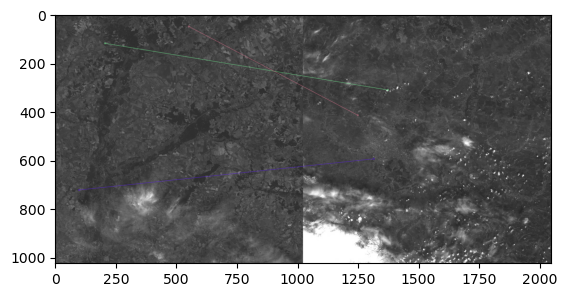

In [37]:
def draw_matches(img1_path, img2_path, features1, features2):
    # Load the images in grayscale mode
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Check if images are loaded properly
    if img1 is None or img2 is None:
        print("Error loading one or both images")
        return

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and recompute descriptors for each image
    kp1, _ = sift.detectAndCompute(img1, None)
    kp2, _ = sift.detectAndCompute(img2, None)

    # Initialize Brute-Force Matcher and match descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(features1, features2, k=2)

    # Apply ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    # Draw first few good matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Convert the image to RGB and display it
    img_matches = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    plt.imshow(img_matches)
    plt.show()

draw_matches(
    r'correct_path_to_image1.jpg',
    r'correct_path_to_image2.jpg',
    features['correct_key_for_image1'],
    features['correct_key_for_image2']
)